In [2]:
from tensorflow.keras.models import load_model
model = load_model("C:/Users/ASUS/Downloads/PCOS/pcos_mobilenetv2_model.h5")

In [5]:
# Importing necessary libraries
import cv2                     # For image processing (OpenCV)
import numpy as np             # For array operations
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For image augmentation and loading

# Function to preprocess ultrasound images
def preprocess_ultrasound(image):
    # Convert grayscale to RGB if image is grayscale (1 channel or 2D array)
    if image.shape[-1] == 1 or len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # If already RGB, convert to grayscale and back to RGB to standardize
    elif image.shape[-1] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Resize to 224x224 (common input size for CNN models like VGG/ResNet)
    image = cv2.resize(image, (224, 224))

    # Apply median blur to reduce noise
    image = cv2.medianBlur(image, 5)

    # Normalize pixel values to [0, 1]
    image = image.astype('float32') / 255.0

    return image

# A simple wrapper for the preprocessing function (in case future logic is needed)
def preprocessing_wrapper(image):
    image = preprocess_ultrasound(image)
    return image

# Define data augmentation strategy for the training data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_ultrasound,  # Apply custom preprocessing
    rotation_range=10,        # Random rotation up to 10 degrees
    zoom_range=0.1,           # Random zoom within range
    horizontal_flip=True      # Random horizontal flip
)

# Data generator for the test data (only preprocessing, no augmentation)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_ultrasound
)

# Paths to training and testing image directories
train_dir = 'C:/Users/ASUS/Downloads/PCOS/org/train'
test_dir = 'C:/Users/ASUS/Downloads/PCOS/org/test'

# Load training images from directory with preprocessing and augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),   # Resize all images to 224x224
    color_mode='rgb',         # Force all images to RGB format
    batch_size=32,            # Load 32 images at a time
    class_mode='binary',      # For binary classification (e.g., PCOS vs Normal)
    shuffle=True              # Shuffle the dataset for training
)

# Load testing images from directory with only preprocessing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),   # Resize images
    color_mode='rgb',         # RGB format
    batch_size=32,            # 32 images per batch
    class_mode='binary',      # Binary labels
    shuffle=False             # Do not shuffle, for evaluation consistency
)


Found 9427 images belonging to 2 classes.
Found 2357 images belonging to 2 classes.


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 394ms/step - accuracy: 0.9346 - loss: 0.1677
Test Loss: 0.1294
Test Accuracy: 0.9601
74/74 ━━━━━━━━━━━━━━━━━━━━ 31s 393ms/step


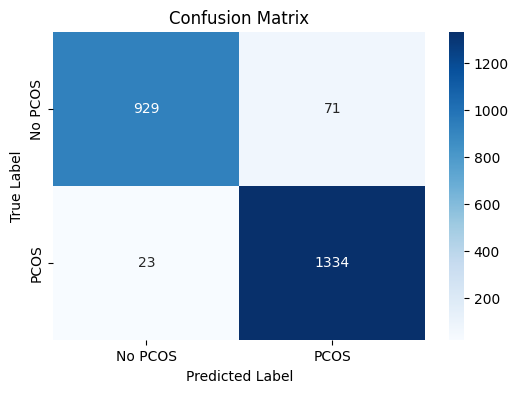


Classification Report:

              precision    recall  f1-score   support

     No PCOS       0.98      0.93      0.95      1000
        PCOS       0.95      0.98      0.97      1357

    accuracy                           0.96      2357
   macro avg       0.96      0.96      0.96      2357
weighted avg       0.96      0.96      0.96      2357



In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate model performance on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict class probabilities and convert to binary predictions
pred_probs = model.predict(test_generator)
pred_classes = (pred_probs > 0.5).astype("int32").flatten()

# Get true labels from the test generator
true_classes = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No PCOS", "PCOS"],
            yticklabels=["No PCOS", "PCOS"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report with precision, recall, f1-score
print("\nClassification Report:\n")
print(classification_report(true_classes, pred_classes, target_names=["No PCOS", "PCOS"]))


74/74 ━━━━━━━━━━━━━━━━━━━━ 28s 377ms/step


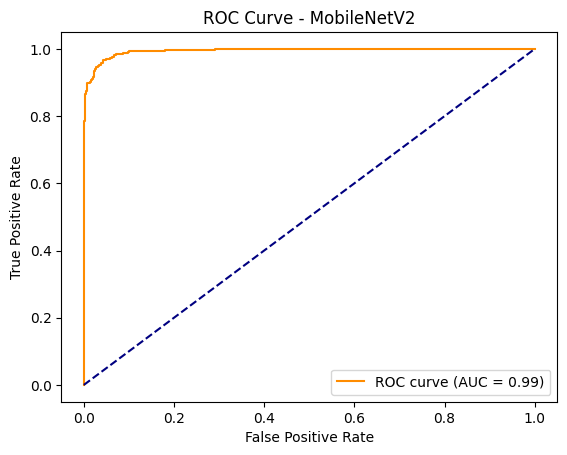

In [7]:
# Get predicted probabilities for test data
y_pred_probs = model.predict(test_generator)  

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate False Positive Rate (fpr), True Positive Rate (tpr) for various thresholds
fpr, tpr, _ = roc_curve(test_generator.classes, y_pred_probs)

# Calculate Area Under the Curve (AUC) value
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MobileNetV2')
plt.legend(loc="lower right")
plt.show()


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_5']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


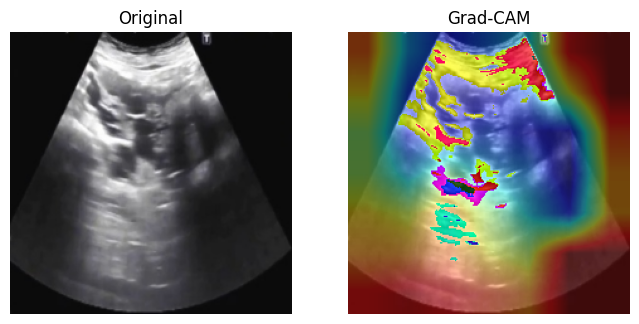

In [9]:
import tensorflow as tf
import matplotlib.cm as cm
from tensorflow.keras.preprocessing import image

# Function to load and preprocess image for model input
def get_img_array(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)      # Load image
    array = image.img_to_array(img)                       # Convert to array
    array = np.expand_dims(array, axis=0)                 # Add batch dimension
    array = array / 255.0                                 # Normalize
    return array, img

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that outputs both conv layer and prediction
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])        # Get predicted class
        class_channel = predictions[:, pred_index]        # Focus on predicted class

    grads = tape.gradient(class_channel, conv_outputs)     # Gradients of conv layer

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))   # Global average pooling
    conv_outputs = conv_outputs[0]                         # Remove batch dimension

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis] # Weighted sum
    heatmap = tf.squeeze(heatmap)                          # Remove last dimension

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)  # Normalize
    return heatmap.numpy()

# Function to overlay heatmap on the original image
def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)                             # Read image
    img = cv2.resize(img, (224, 224))                      # Resize to model input
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Resize heatmap
    heatmap_colored = cm.jet(heatmap_resized)[..., :3] * 255              # Apply colormap
    superimposed_img = heatmap_colored * alpha + img                    # Overlay heatmap
    superimposed_img = np.uint8(superimposed_img)

    # Display original and heatmap images side by side
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Choose an example PCOS image from the test set
example_path = os.path.join(test_dir, 'pcos', os.listdir(os.path.join(test_dir, 'pcos'))[0])

# Generate heatmap and display Grad-CAM
img_array, original_img = get_img_array(example_path)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1")
display_gradcam(example_path, heatmap)
